# Pylops-distributed - Marchenko redatuming with 3D dataset

### Author: M.Ravasi

This notebook extends the standard *Marchenko* algorithm in PyLops to distibuted computing with dask

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import zarr
import pylops
import pylops_distributed

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt
from scipy.spatial import Voronoi, ConvexHull, voronoi_plot_2d

from pylops.basicoperators import *
from pylops.waveeqprocessing.mdd       import MDC
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.waveeqprocessing.marchenko import directwave
from pylops.utils import dottest

from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.basicoperators import Diagonal as dDiagonal
from pylops_distributed.basicoperators import Identity as dIdentity
from pylops_distributed.basicoperators import Roll as dRoll
from pylops_distributed.waveeqprocessing.mdd import MDC as dMDC
from pylops_distributed.waveeqprocessing.marchenko import Marchenko as dMarchenko
from pylops_distributed.optimization.cg import cg as dcg
from pylops_distributed.optimization.cg import cgls as dcgls

In [2]:
os.environ["STORE_PATH"] = "/project/fsenter/mrava/"

In [3]:
client = pylops_distributed.utils.backend.dask(hardware='multi', client='be-linrgsn085:8786')
client

Client Scheduler: tcp://be-linrgsn085:8786 Dashboard: http://be-linrgsn085:8787/status,Cluster Workers: 8 Cores: 96 Memory: 1.08 TB


In [4]:
client.restart()

Client Scheduler: tcp://be-linrgsn085:8786 Dashboard: http://be-linrgsn085:8787/status,Cluster Workers: 8 Cores: 96 Memory: 1.08 TB


In [5]:
nworkers = len(np.array(list(client.ncores().values())))
ncores = np.sum(np.array(list(client.ncores().values())))
print('Nworkers', nworkers)
print('Ncores', ncores)

Nworkers 8
Ncores 96


## Inputs

Input parameters 

In [6]:
vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 300         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 10         # iterations
subsampling = 8     # subsampling of src-recs compared to original data
displaygeom = False # display geometry

inputfile_aux = '../../data/marchenko/3DMarchenko_auxiliary_2.npz' 
zarrfile = os.environ["STORE_PATH"]+'Marchenko3D/input3D_sub%d_ffirst.zarr' % subsampling

Load input

In [7]:
inputdata_aux = np.load(inputfile_aux)

Read geometry

In [8]:
# Receivers
r = inputdata_aux['recs'][::subsampling].T
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata_aux['srcs'][::subsampling].T
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata_aux['vs'] 

# Density model
rho = inputdata_aux['rho']
z, x, y = inputdata_aux['z'], inputdata_aux['x'], inputdata_aux['y']

Identify areal extent of each source-receiver to be used in MDC integral

In [9]:
def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
    return v, vol

# find area of each volume - note that areas at the edges and on vertex are unbounded, ̈́
# we will assume that they are and use the minimum are for all points in this example
vertex, vols = voronoi_volumes(r[:2].T)
darea = np.min(np.unique(vols))
print('Integration area %f' % darea)

Integration area 1800.000000


Read data

In [10]:
# time axis
ot, dt, nt = 0, 2.5e-3, 601
t = np.arange(nt)*dt

In [11]:
dRtwosided_fft = 2 * da.from_zarr(zarrfile)  # 2 * as per theory you need 2*R

In [12]:
nchunks = [max(nfmax // ncores, 1), ns, nr]
dRtwosided_fft = dRtwosided_fft.rechunk(nchunks)
dRtwosided_fft = client.persist(dRtwosided_fft)
client.rebalance(dRtwosided_fft)
dRtwosided_fft

,Array,Chunk
Bytes,3.61 GB,36.07 MB
Shape,"(300, 1226, 1226)","(3, 1226, 1226)"
Count,100 Tasks,100 Chunks
Type,complex64,numpy.ndarray


In [13]:
if displaygeom:
    Rmid_fft = (dRtwosided_fft[:, ns // 2]).compute()
    Rmid = np.fft.irfft(Rmid_fft, n=2*nt-1, axis=0)

Read subsurface fields and wavelet to apply to subsurface fields

In [14]:
Gsub = inputdata_aux['G'][:, ::subsampling]
G0sub = inputdata_aux['G0'][:, ::subsampling]
wav = ricker(t[:51], 20)[0]
wav_c = np.argmax(wav)

# convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

# integrate to go back to monopole source
Gsub = np.cumsum(Gsub, axis=0)
G0sub = np.cumsum(G0sub, axis=0)

Visualization

In [15]:
if displaygeom:
    fig = plt.figure(figsize=(18, 6))
    plt.suptitle('Geometry and Data', y=1.04, fontsize=18, fontweight='bold')
    ax0 = plt.subplot2grid((5, 10), (0, 0), rowspan=2, colspan=4)
    ax1 = plt.subplot2grid((5, 10), (2, 0), rowspan=3, colspan=4)
    ax2 = plt.subplot2grid((5, 10), (0, 4), rowspan=2, colspan=2)
    ax3 = plt.subplot2grid((5, 10), (2, 4), rowspan=3, colspan=2)
    ax4 = plt.subplot2grid((5, 10), (0, 6), rowspan=5, colspan=6)

    ax0.imshow(rho[:,:,np.argmin(np.abs(z-vs[2]))], cmap='gray', origin='lower',
               vmin=2000, vmax=6000, extent = (x[0], x[-1], y[0], y[-1]))
    ax0.scatter(s[0], s[1], marker='.', s=50, c='r', edgecolors='k')
    ax0.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
    ax0.axis('tight')
    ax0.set_ylabel('x [m]')
    ax0.set_xlim(x[0], x[-1])
    ax0.set_ylim(y[0], y[-1])
    #ax0.text(50, 1000, '(a)', va="center", color='k', fontsize=12,
    #         bbox=dict( fc='w', ec='k'))
    ax0.set_xticklabels([])

    ax1.imshow(rho[np.argmin(np.abs(x-vs[1]))].T, cmap='gray', vmin=1000, vmax=5000,
               extent = (x[0], x[-1], z[-1], z[0]))
    ax1.axhline(r[2, 0], color='b', lw=4)
    ax1.axhline(s[2, 0], color='r', linestyle='--', lw=4)
    ax1.scatter(vs[0], vs[2], marker='.', s=400, c='m', edgecolors='k')
    ax1.axis('tight')
    ax1.set_xlabel('x [m]')
    ax1.set_ylabel('z [m]')
    ax1.set_xlim(x[0], x[-1])
    #ax1.text(50, 100, '(b)', va="center", color='k', fontsize=15,
    #         bbox=dict( fc='w', ec='k'))

    voronoi_plot_2d(vertex, ax=ax2, show_points=False,
                    show_vertices=False, line_colors='k',
                    line_width=2, line_alpha=0.6, point_size=10)
    ax2.scatter(s[0], s[1], marker='.', s=100, c='r', edgecolors='k')
    ax2.scatter(vs[0], vs[1], marker='.', s=400, c='m', edgecolors='k')
    ax2.set_xlim(vs[0]-80, vs[0]+80)
    ax2.set_ylim(vs[1]-80, vs[1]+80)
    #ax2.text(550, 600, '(c)', va="center", color='k', fontsize=15,
    #         bbox=dict( fc='w', ec='k'))

    ax3.imshow(rho[np.argmin(np.abs(y-vs[0]))].T, cmap='gray', vmin=1000, vmax=5000,
               extent = (y[0], y[-1], z[-1], z[0]))
    ax3.axhline(r[2, 0], color='b', lw=4)
    ax3.axhline(s[2, 0], color='r', linestyle='--', lw=4)
    ax3.scatter(vs[1], vs[2], marker='.', s=400, c='m', edgecolors='k')
    ax3.set_xlabel('y [m]')
    ax3.axis('tight')
    ax3.set_xlim(y[0], y[-1]);
    ax3.set_yticklabels([])
    #ax3.text(100, 100, '(d)', va="center", color='k', fontsize=15,
    #         bbox=dict( fc='w', ec='k'))

    ax4.imshow(Rmid[nt:], cmap='gray', vmin=-1e-5, vmax=1e-5, extent=(0, nr, t[-1], t[0]))
    ax4.axis('tight')
    ax4.set_xlim(nr//2-400, nr//2+400)
    ax4.set_xlabel('# Rec')
    ax4.set_ylabel('t [s]')
    ax4.set_ylim(0.8, 0.)
    #ax4.text(1130, 0.05, '(f)', va="center", color='k', fontsize=15,
    #         bbox=dict( fc='w', ec='k'))

    plt.tight_layout()
    #plt.savefig('Figures/geometry_subsampling%d.eps' % subsampling, bbox_inches='tight')
    plt.savefig('Figures/geometry_subsampling%d.png' % subsampling, dpi=300, bbox_inches='tight')

## Marchenko preparation

Create window

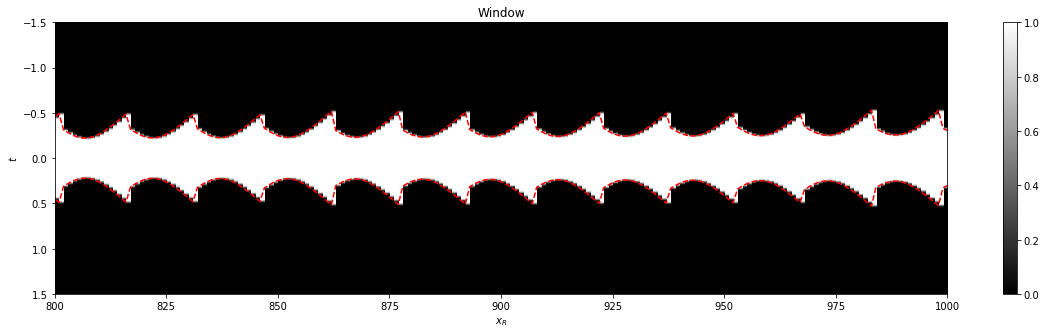

In [16]:
# direct arrival window - traveltime
distVS = np.sqrt((vs[0]-r[0])**2 +(vs[1]-r[1])**2 +(vs[2]-r[2])**2)
directVS = distVS/vel
directVS_off = directVS - toff

# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((np.fliplr(w), w[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    
    
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(20, 5))
im = ax.imshow(w.T, cmap='gray', extent=(0, nr, t[-1], -t[-1]))
ax.plot(np.arange(0, nr), directVS_off, '--r')
ax.plot(np.arange(0, nr), -directVS_off, '--r')
ax.set_title('Window') 
ax.set_xlabel(r'$x_R$')
ax.set_ylabel(r'$t$')
ax.axis('tight')
ax.set_xlim(800, 1000);
fig.colorbar(im, ax=ax);

Create analytical direct wave

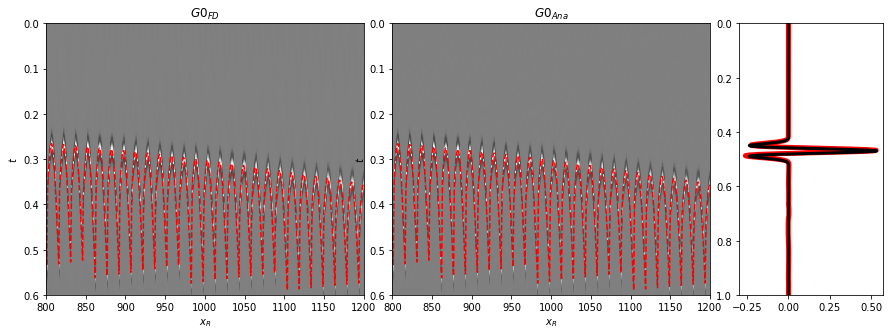

In [17]:
G0sub_ana = directwave(wav, directVS, nt, dt, nfft=2**11, dist=distVS, kind='3d') 

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(G0sub/G0sub.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(0, nr, t[-1], t[0]))
ax1.set_title(r'$G0_{FD}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.plot(np.arange(0, nr), directVS, '--r')
ax1.axis('tight')
ax1.set_ylim(.6, 0)
ax1.set_xlim(800, 1200)
ax2.imshow(G0sub_ana/G0sub_ana.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(0, nr, t[-1], t[0]))
ax2.set_title(r'$G0_{Ana}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.plot(np.arange(0, nr), directVS, '--r')
ax2.axis('tight')
ax2.set_ylim(.6, 0)
ax2.set_xlim(800, 1200)
ax3.plot(G0sub[:, nr//2-10]/G0sub.max(), t, 'r', lw=5)
ax3.plot(G0sub_ana[:, nr//2-10]/G0sub_ana.max(), t, 'k', lw=3)
ax3.set_ylim(1., 0);

For now we will use the direct wave obtained via finite-difference, but we will show later that Marchenko redatuming can converge to the correct solution also when using an analytical direct wave.

## Inversion

Create distributed Marchenko operator

In [18]:
# Operators
dRop = dMDC(dRtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=darea, twosided=True,
            saveGt=False)#, todask=(True, True))
dR1op = dMDC(dRtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=darea, twosided=True, 
             saveGt=False, conj=True)#, todask=(True, True))
dRollop = dRoll((2*nt-1) * nr,
               dims=(2*nt-1, nr),
               dir=0, shift=-1)

# Input focusing function
dfd_plus =  np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr))))
dfd_plus = da.from_array(dfd_plus)

In [19]:
dfd_plus

dask.array<array, shape=(1201, 1226), dtype=float64, chunksize=(1201, 1226)>

In [20]:
dWop = dDiagonal(w.T.flatten())
dIop = dIdentity(nr*(2*nt-1))

dMop = pylops_distributed.VStack([pylops_distributed.HStack([dIop, -1*dWop*dRop]),
                                 pylops_distributed.HStack([-1*dWop*dRollop*dR1op, dIop])])*pylops_distributed.BlockDiag([dWop, dWop])
dGop = pylops_distributed.VStack([pylops_distributed.HStack([dIop, -1*dRop]),
                                 pylops_distributed.HStack([-1*dRollop*dR1op, dIop])])

#ddottest(dGop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), chunks=(2*nr*(2*nt-1), 2*nr*(2*nt-1)), verb=True)
#ddottest(dMop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), chunks=(2*nr*(2*nt-1), 2*nr*(2*nt-1)), verb=True);

Run standard redatuming as benchmark

In [21]:
dp0_minus = dRop * dfd_plus.flatten()
dp0_minus = dp0_minus.reshape((2*nt-1), nr).T

In [22]:
dp0_minus

dask.array<transpose, shape=(1226, 1201), dtype=float64, chunksize=(1226, 1201)>

Create data

In [23]:
dd = dWop*dRop*dfd_plus.flatten()
dd = da.concatenate((dd.reshape(2*nt-1, nr), da.zeros((2*nt-1, nr))))

In [24]:
dd

dask.array<concatenate, shape=(2402, 1226), dtype=float64, chunksize=(1201, 1226)>

Adjoint and inverse focusing functions

In [25]:
df1_adj = dMop.H * dd.flatten()
#df1_inv = dcg(dMop.H * dMop, dMop.H * dd.ravel(), 
#              niter=10, compute=False)[0]
df1_inv = dcgls(dMop, dd.ravel(), niter=n_iter, tol=0, client=client)[0]
df1_adj = df1_adj.reshape(2*(2*nt-1), nr)
df1_inv = df1_inv.reshape(2*(2*nt-1), nr)

Add initial guess to estimated focusing functions

In [26]:
df1_adj_tot = df1_adj + da.concatenate((da.zeros((2*nt-1, nr)),
                                        dfd_plus))

df1_inv_tot = df1_inv + da.concatenate((da.zeros((2*nt-1, nr)), 
                                        dfd_plus))

Estimate Green's functions

In [27]:
dg_adj = dGop * df1_adj_tot.flatten()
dg_inv = dGop * df1_inv_tot.flatten()

dg_adj = dg_adj.reshape(2*(2*nt-1), nr)
dg_inv = dg_inv.reshape(2*(2*nt-1), nr)

In [28]:
#dd, dp0_minus, df1_adj_tot, df1_inv_tot, dg_adj, dg_inv = \
#    da.compute(dd, dp0_minus, df1_adj_tot, df1_inv_tot, dg_adj, dg_inv)

# if planning to time, need to run dgls without persist (take away client=client)
t0 = time.time()
dd, dp0_minus, df1_inv_tot, dg_inv = \
    da.compute(dd, dp0_minus, df1_inv_tot, dg_inv)
print('Inversion took %f s' % (time.time() - t0))

Inversion took 100.922146 s


Extract up and down focusing and Green's functions from model vectors

In [29]:
# need to understand why...
#dg_adj = np.real(dg_adj)
dg_inv = np.real(dg_inv)

In [30]:
#df1_adj_minus, df1_adj_plus = df1_adj_tot[:(2*nt-1)].T, df1_adj_tot[(2*nt-1):].T
df1_inv_minus, df1_inv_plus = df1_inv_tot[:(2*nt-1)].T, df1_inv_tot[(2*nt-1):].T

#dg_adj_minus, dg_adj_plus =  -dg_adj[:(2*nt-1)].T, np.fliplr(dg_adj[(2*nt-1):].T)
dg_inv_minus, dg_inv_plus =  -dg_inv[:(2*nt-1)].T, np.fliplr(dg_inv[(2*nt-1):].T)

dg_inv_tot = dg_inv_minus + dg_inv_plus

Visualization

In [31]:
# Need to recreate combined data as new implementation stacks over time instead of space
dd = np.concatenate((dd[:(2*nt-1)], dd[(2*nt-1):]), axis=1).T
#df1_adj_tot = np.concatenate((df1_adj_tot[:(2*nt-1)], df1_adj_tot[(2*nt-1):]), axis=1).T
df1_inv_tot = np.concatenate((df1_inv_tot[:(2*nt-1)], df1_inv_tot[(2*nt-1):]), axis=1).T
#dg_adj = np.concatenate((dg_adj[:(2*nt-1)], dg_adj[(2*nt-1):]), axis=1).T
dg_inv = np.concatenate((dg_inv[:(2*nt-1)], dg_inv[(2*nt-1):]), axis=1).T

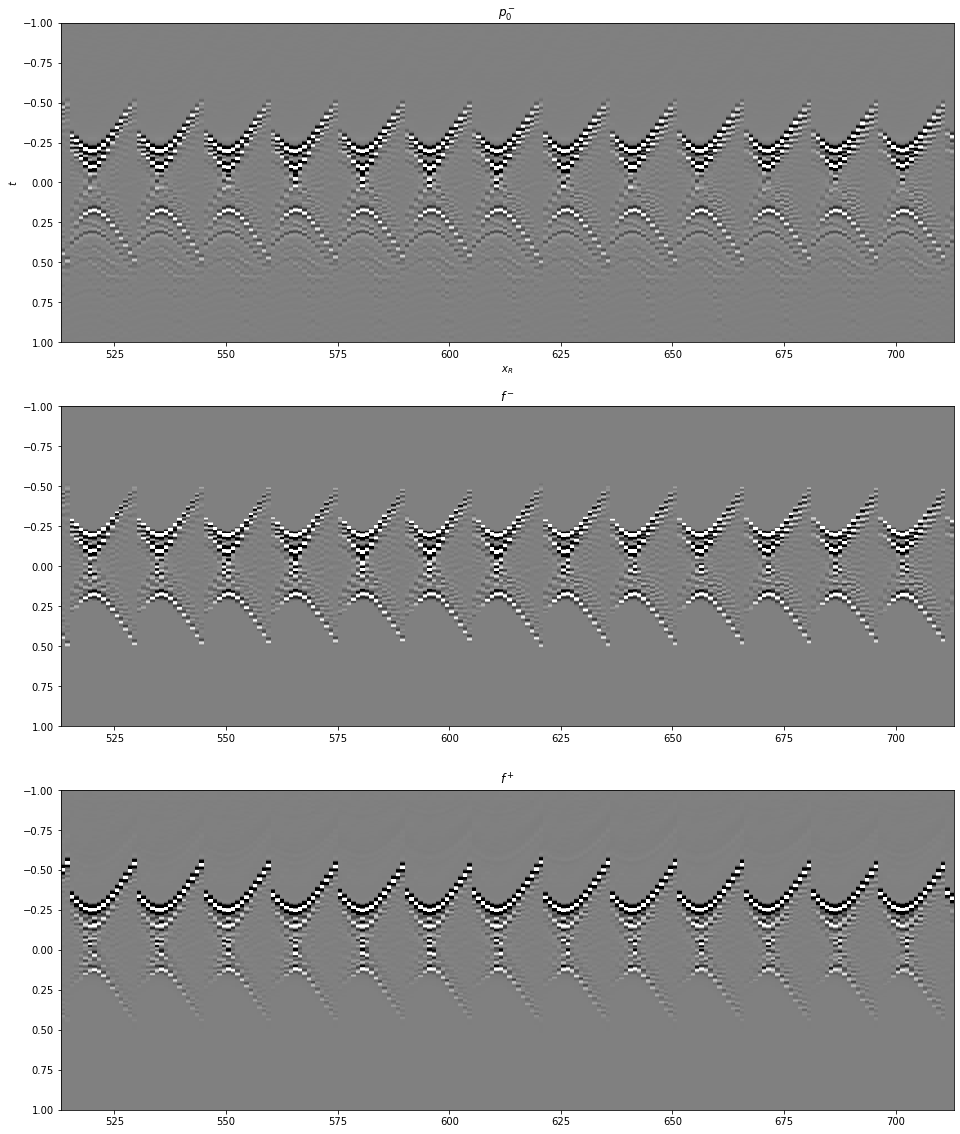

In [32]:
fig, axs = plt.subplots(3, 1, sharey=True, figsize=(16, 20))
axs[0].imshow(dp0_minus.T, cmap='gray', vmin=-6e3, vmax=6e3, extent=(0, nr, t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_xlim(nr//2-100,nr//2+100)
axs[0].set_ylim(1, -1)
axs[1].imshow(df1_inv_minus.T, cmap='gray', vmin=-6e3, vmax=6e3, extent=(0, nr, t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_xlim(nr//2-100,nr//2+100)
axs[1].set_ylim(1, -1)
axs[2].imshow(df1_inv_plus.T, cmap='gray', vmin=-6e3, vmax=6e3, extent=(0, nr, t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_xlim(nr//2-100,nr//2+100)
axs[2].set_ylim(1, -1);

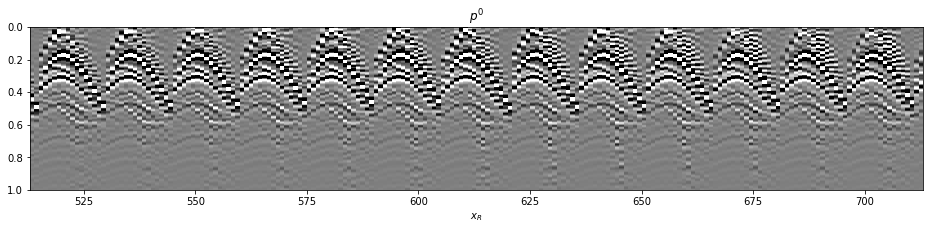

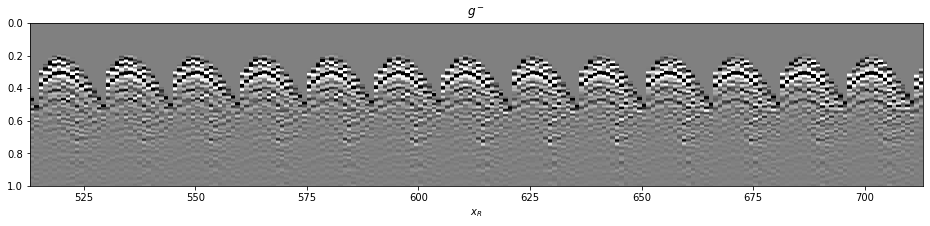

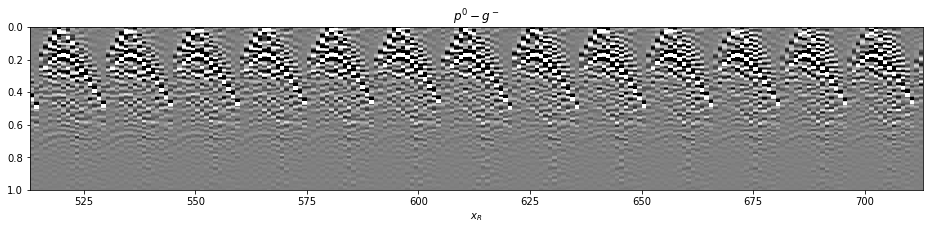

In [33]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(16, 3))
ax.imshow(dp0_minus.T, cmap='gray', vmin=-1e3, vmax=1e3, 
          extent=(0, nr, t[-1], -t[-1]))
ax.set_title(r'$p^0$'), ax.set_xlabel(r'$x_R$')
ax.axis('tight')
ax.set_ylim(1., 0)
ax.set_xlim(nr//2-100,nr//2+100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(16, 3))
ax.imshow(dg_inv_minus.T * (1-w.T), cmap='gray', vmin=-1e3, vmax=1e3, 
          extent=(0, nr, t[-1], -t[-1]))
ax.set_title(r'$g^-$'), ax.set_xlabel(r'$x_R$')
ax.axis('tight')
ax.set_ylim(1., 0)
ax.set_xlim(nr//2-100,nr//2+100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(16, 3))
ax.imshow(dp0_minus.T - dg_inv_minus.T, cmap='gray', vmin=-1e3, vmax=1e3, 
          extent=(0, nr, t[-1], -t[-1]))
ax.set_title(r'$p^0 - g^-$'), ax.set_xlabel(r'$x_R$')
ax.axis('tight')
ax.set_ylim(1., 0)
ax.set_xlim(nr//2-100,nr//2+100);

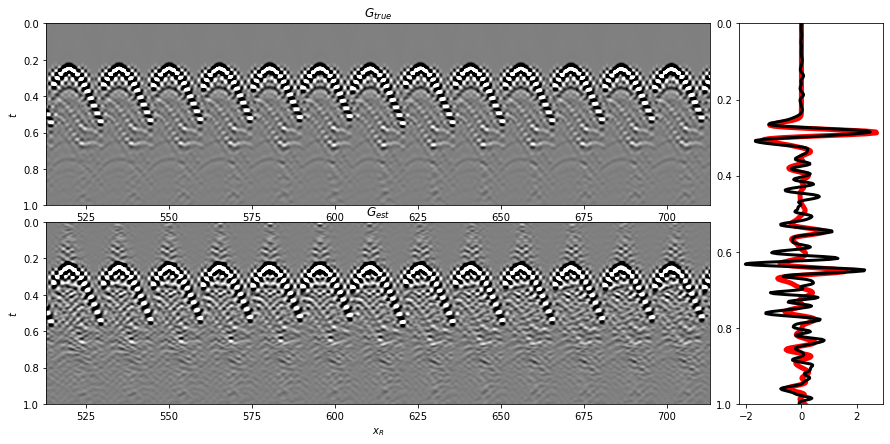

In [34]:
fig = plt.figure(figsize=(15, 7))
ax1 = plt.subplot2grid((4, 5), (0, 0), rowspan=2, colspan=4)
ax2 = plt.subplot2grid((4, 5), (2, 0), rowspan=2, colspan=4)
ax3 = plt.subplot2grid((4, 5), (0, 4), rowspan=4)

ax1.imshow(Gsub, cmap='gray', vmin=-5e3, vmax=5e3, extent=(0, nr, t[-1], t[0]),
           interpolation='sinc')
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1., 0)
ax1.set_xlim(nr//2-100,nr//2+100)
ax2.imshow(dg_inv_tot.T, cmap='gray', vmin=-5e3, vmax=5e3, extent=(0, nr, t[-1], -t[-1]),
           interpolation='sinc')
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1., 0)
ax2.set_xlim(nr//2-100,nr//2+100)

ax3.plot(np.exp(4*t) * Gsub[:, nr//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(np.exp(4*t) * dg_inv_tot[nr//2, nt-1:]/dg_inv_tot.max(), t, 'k', lw=3)
ax3.set_ylim(1., 0);

Save results to be visualized later together with others from different subsampling

In [35]:
#np.savez('Figures/gest_subsampling%d' % subsampling, dp0_minus=dp0_minus, 
#         dg_inv_minus=dg_inv_minus, dg_inv_tot=dg_inv_tot, w=w)

In [36]:
client.close()